In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds
import isi_indexing as ii
from readout import load_results

import conf.isi5_500 as cfg
from demonstrator import demonstrator

import styling

In [2]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [3]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [4]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [5]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs]

In [6]:
nspikes = dd.io.load('nspikes.h5')

# Figure 3

In [7]:
net, ipair, istim, isi, templ = [demonstrator[k] for k in ('net', 'ipair', 'istim', 'isi', 'templ')]
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]
tmax = 0
pmax = 0
hists = {STD: {TA: None for TA in cfg.TAs} for STD in cfg.STDs}
bspikes = {STD: {TA: {} for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        res = load_results(
            cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
            compress=True, tmax=100*ms, process_dynamics=False,
            raw_fbase=cfg.raw_fbase.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))
        histograms = {cond: res['spikes'][ipair][stim][cond]['spike_hist']
                      for cond in conds}
        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h for h in histograms.values()]))
        tmax = max(tmax, np.max(index_t)+1)
        hists[STD][TA] = histograms
        pmax = max(pmax, *[h.sum(0).max() for h in histograms.values()])

        for cond in conds:
            ep = res['pairs'][ipair][cond][stim]
            seq = res['sequences'][ep]
            bspikes[STD][TA][cond] = get_bspikes(res, ep)[:, seq==cfg.stimuli[stim]]

In [8]:
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for cond in conds:
            b = bspikes[STD][TA][cond]
            if b.shape[-1] != tmax:
                shape = list(b.shape)
                shape[-1] = tmax - b.shape[-1]
                bspikes[STD][TA][cond] = np.concatenate(
                    [b, np.zeros_like(b, shape=shape)],
                    axis=-1
                )

In [9]:
_pmax = np.amax([hists[STD][TA][cond].sum(0) for STD in cfg.STDs for TA in cfg.TAs for cond in conds], 0)
tmax = np.argmax(np.cumsum(_pmax > .01*pmax))

In [10]:
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for cond, b in bspikes[STD][TA].items():
            bspikes[STD][TA][cond] = b[:, :, :tmax]

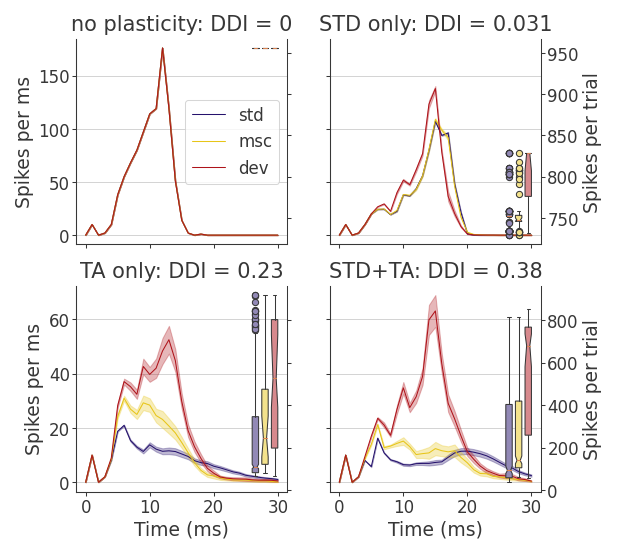

In [11]:
def panel_samples(axs):
    time = np.arange(tmax) * cfg.params['dt']
    twins = np.empty_like(axs, object)
    for STD in cfg.STDs:
        for TA in cfg.TAs:
            ax = axs[TA, STD]
            y2 = twins[TA, STD] = ax.twinx()
            if STD:
                ax.sharey(axs[TA, 0])
                y2.sharey(twins[TA, 0])
                y2.set_ylabel('Spikes per trial')
            else:
                ax.set_ylabel('Spikes per ms')
                y2.label_outer()
            histograms = hists[STD][TA]
            for i, (cond, h) in enumerate(histograms.items()):
                pspike = h.sum(0)[:tmax]
                b = bspikes[STD][TA][cond]
                ax.plot(time/ms, pspike, c=pu.colors[cond], label=cond)
                se = b.sum(0).std(0) / np.sqrt(b.shape[1])
                ax.fill_between(time/ms, pspike-se, pspike+se, color=pu.colors[cond], alpha=.3)

                c = pu.alpha_to_color(pu.colors[cond], .5)
                y2.boxplot(b.sum((0,2)), positions=[tmax - 4.5 + 1.5*i], widths=1, notch=True, bootstrap=10000,
                           patch_artist=True, manage_ticks=False,
                           boxprops={'facecolor': c}, flierprops={'markerfacecolor': c})

            if TA:
                ax.set_xlabel('Time (ms)')
            ax.set_title(f'{label(STD, TA)}: DDI = {index(histograms["dev"].sum(), histograms["msc"].sum()):.2g}')
            ax.yaxis.grid(True)
            sns.despine(ax=ax)
            sns.despine(ax=y2, right=False)
            ax.label_outer()
    axs[0][0].legend(loc='right')
fig, axs = plt.subplots(2, 2, figsize=(4,4), sharex=True, dpi=150)
panel_samples(axs)

Deviance detection index
STD only != 0: Z = -1.12, p = 0.262
STD only > 0: Z = -1.12, p = 0.869, median -0.000214
TA only > 0: Z = 5.81, p = 3.1e-09, median 0.0772
STD+TA > 0: Z = 6.12, p = 4.75e-10, median 0.114
STD+TA > TA only: Z = 3.24, p = 0.000604
STD+TA > STD only: Z = 6.47, p = 4.95e-11
STD+TA > summation: Z = 3.92, p = 4.52e-05


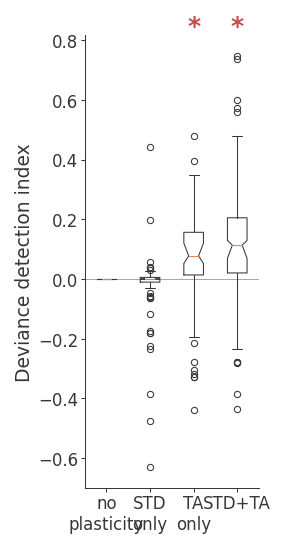

In [12]:
def panel_stats(ax, c0='dev', c1='msc', ylabel='Deviance detection index'):
    idx = [index(nspikes[cfg.ISIs[0]][STD][TA][c0], nspikes[cfg.ISIs[0]][STD][TA][c1]) for TA, STD in plasticity]
    labels = [label(STD, TA) for TA, STD in plasticity]
    ax.boxplot(idx, notch=True, bootstrap=10000)
    ax.set_xticks(range(1,5), [l.replace(' ', '\n') for l in labels])
    ax.set_ylabel(ylabel)
    ax.axhline(0, **styling.axline_kwargs)
    sns.despine(ax=ax)

    print(ylabel)
    imax = np.amax(idx)
    for i, ix in enumerate(idx):
        if np.all(ix==0):
            continue
        test = stats.wilcoxon(ix, alternative='greater', method='approx')
        if test.pvalue < .05:
            ax.text(i+1, 1.1*imax, '*', {'color': 'r', 'ha': 'center'}, **styling.label_kwargs)
        else:
            test2 = stats.wilcoxon(ix, alternative='two-sided', method='approx')
            print(f'{labels[i]} != 0: Z = {test2.zstatistic:.3g}, p = {test2.pvalue:.3g}')
        print(f'{labels[i]} > 0: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median {np.median(ix):.3g}')
    
    test = stats.wilcoxon(idx[-1], idx[-2], alternative='greater', method='approx')
    print(f'{labels[-1]} > {labels[-2]}: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(idx[-1], idx[-3], alternative='greater', method='approx')
    print(f'{labels[-1]} > {labels[-3]}: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(idx[-1], idx[-2]+idx[-3], alternative='greater', method='approx')
    print(f'{labels[-1]} > summation: Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(1.5,4), dpi=150)
panel_stats(ax)

DDI
STD only != 0: Z = -1.12, p = 0.262
STD only > 0: Z = -1.12, p = 0.869, median -0.000214
TA only > 0: Z = 5.81, p = 3.1e-09, median 0.0772
STD+TA > 0: Z = 6.12, p = 4.75e-10, median 0.114
STD+TA > TA only: Z = 3.24, p = 0.000604
STD+TA > STD only: Z = 6.47, p = 4.95e-11
STD+TA > summation: Z = 3.92, p = 4.52e-05


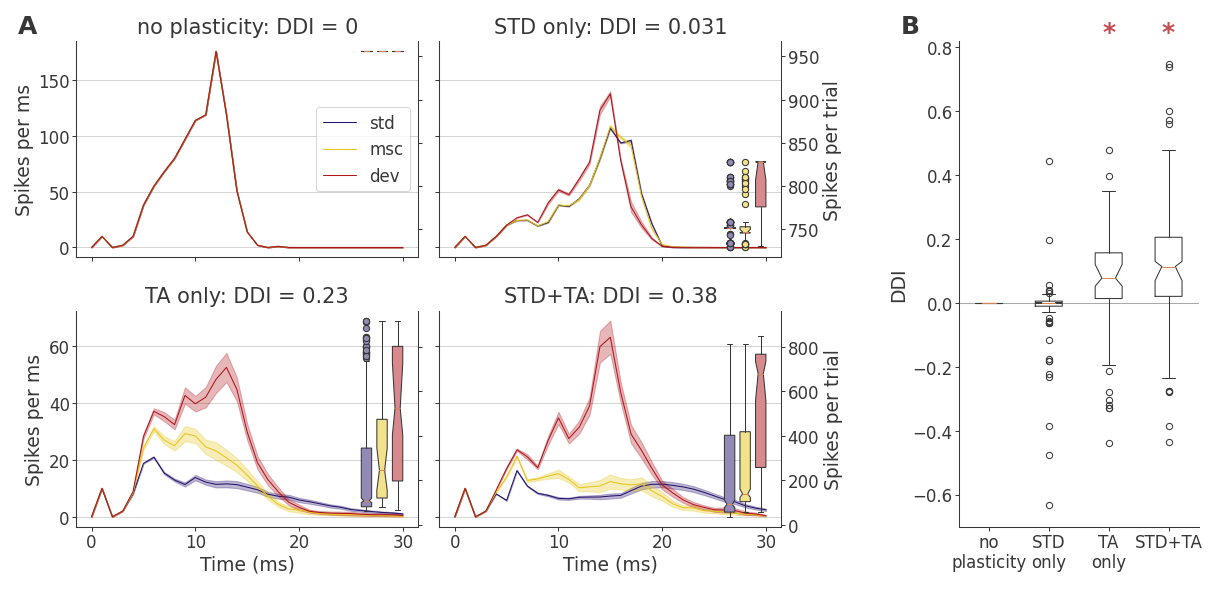

In [13]:
fig = plt.figure(figsize=pu.fullwidth(3), layout='constrained', dpi=150)
gs = fig.add_gridspec(2, 4, width_ratios=(2, 2, .2, 1.4))

axs = [[None for TA in cfg.TAs] for STD in cfg.STDs]
for STD in cfg.STDs:
    for TA in cfg.TAs:
        axs[STD][TA] = fig.add_subplot(gs[STD, TA])
panel_samples(np.asarray(axs))
pu.label_panel(axs[0][0], 0, left=.8)

ax = fig.add_subplot(gs[:, 3])
panel_stats(ax, ylabel='DDI')
pu.label_panel(ax, 1, left=.7)

plt.savefig('paper-1/Fig3.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-ablation.pdf')

# Figure 2

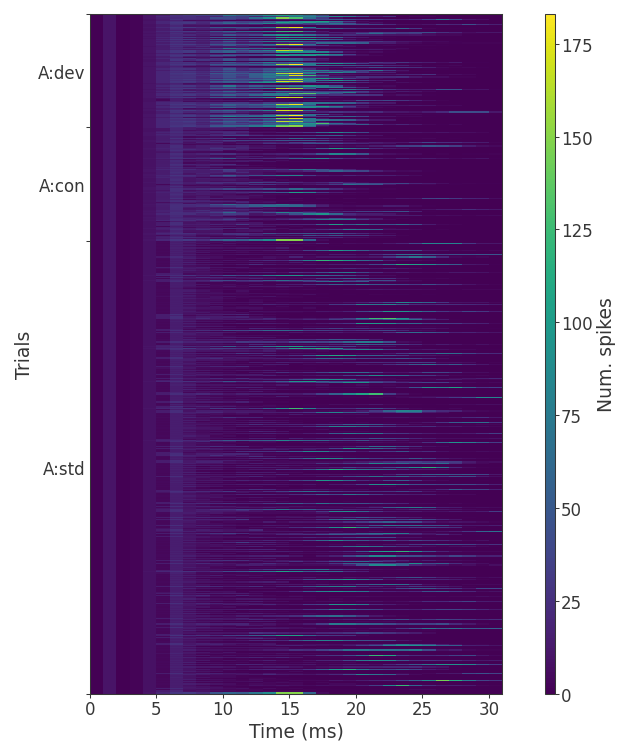

In [14]:
def panel_raster(ax, cax, bspikes):
    data = np.concatenate([b for b in bspikes.values()], 1).sum(0)
    x = np.arange(data.shape[1] + 1)*cfg.params['dt']/msecond
    y = np.arange(data.shape[0] + 1)
    m = ax.pcolormesh(x, y, data, vmin=0, cmap=styling.cmap_seq, shading='flat', rasterized=True)
    plt.colorbar(m, cax=cax, label='Num. spikes')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Trials')
    offset = 0
    limits = [0]
    for b in bspikes.values():
        limits += [offset + b.shape[1]]
        offset += b.shape[1]
    ax.set_yticks(limits, [])
    ax.set_yticks([(lo+hi)/2 for lo, hi in zip(limits, limits[1:])], [pu.sseq[k] for k in bspikes.keys()], minor=True)
    ax.tick_params('y', which='minor', length=0, pad=2)
fig, axs = plt.subplots(1, 2, figsize=(4,6), dpi=150, width_ratios=(40,1))
panel_raster(*axs, bspikes[1][1])

In [15]:
import spatial

In [16]:
res = dd.io.load(cfg.netfile.format(net=demonstrator['net']))
X, Y, W = res['X']*meter, res['Y']*meter, res['W']
stimulated_neurons = res['stimulated_neurons']
W[np.isnan(W)] = 0
Xstim, Ystim = spatial.create_stimulus_locations(cfg.params)
dA = spatial.get_distance_to_stim(cfg.stimuli[cfg.pairings[demonstrator['ipair']][demonstrator['istim']]], W, X, Y, cfg.params)

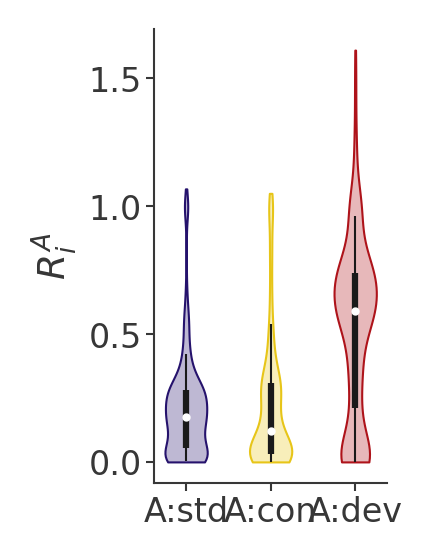

In [17]:
def panel_neuron_responses(ax):
    neuron_responses = {key: b.sum(2).mean(1)[dA>0] for key, b in bspikes[1][1].items()}

    for i, (cond, r) in enumerate(neuron_responses.items()):
        parts = ax.violinplot([r], positions=[i], showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(pu.alpha_to_color(pu.colors[cond], .3))
            pc.set_edgecolor(pu.colors[cond])
            pc.set_alpha(1)
        
        dec1, quartile1, median, quartile3, dec9 = np.percentile(r, [10, 25, 50, 75, 90])
        ax.vlines([i], [quartile1], [quartile3], color='k', lw=1.5)
        ax.vlines([i], [dec1], [dec9], color='k', lw=.5)
        ax.plot(i, median, 'wo', ms=1)

    ax.set_xticks(range(len(neuron_responses)), [pu.sseq[k] for k in neuron_responses.keys()])
    ax.set_ylabel(f'${pu.R(stim="A", index="i")}$')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(1,2), dpi=300)
panel_neuron_responses(ax)

Grey distribution ignores 204 neurons.


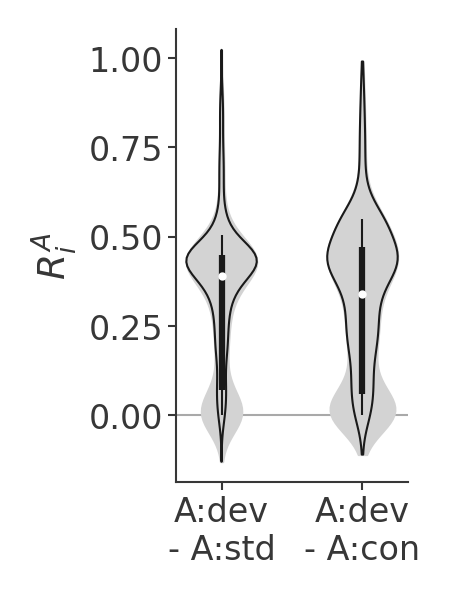

In [18]:
def panel_neuron_contrast(ax):
    neuron_responses = {key: b.sum(2).mean(1)[dA>0] for key, b in bspikes[1][1].items()}
    mask = np.sum([r > 0.1 for r in neuron_responses.values()], 0).astype(bool)
    print(f'Grey distribution ignores {(~mask).sum()} neurons.')

    ticks = []
    for i, (c1, c2) in enumerate((('std','dev'), ('msc','dev'))):
        r = neuron_responses[c2] - neuron_responses[c1]

        # Unmasked
        parts = ax.violinplot([r], positions=[i], showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor('lightgrey')
            pc.set_edgecolor('lightgrey')
            pc.set_alpha(1)

        # Masked
        parts = ax.violinplot([r[mask]], positions=[i], showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor('none')
            pc.set_edgecolor('k')
            pc.set_alpha(1)
        ticks.append(f'{pu.sseq[c2]}\n- {pu.sseq[c1]}')

        dec1, quartile1, median, quartile3, dec9 = np.percentile(r, [10, 25, 50, 75, 90])
        ax.vlines([i], [quartile1], [quartile3], color='k', lw=1.5)
        ax.vlines([i], [dec1], [dec9], color='k', lw=.5)
        ax.plot(i, median, 'wo', ms=1)


    ax.axhline(0, **styling.axline_kwargs)
    ax.set_xticks(range(len(ticks)), ticks)
    ax.set_ylabel(f'${pu.R(stim="A", index="i")}$')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(1,2), dpi=300)
panel_neuron_contrast(ax)

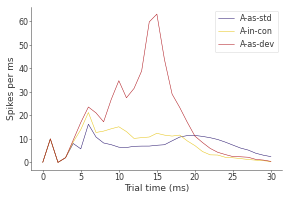

In [19]:
def panel_response(ax, bspikes, dt, ylabel='Spikes per ms'):
    for cond in conds:
        ax.plot(np.arange(bspikes[cond].shape[2]) * dt/ms, bspikes[cond].sum(0).mean(0), c=pu.colors[cond], label=pu.seq[cond])
    ax.set_xlabel('Trial time (ms)')
    ax.set_ylabel(ylabel)
    ax.legend()
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(4.5,3))
panel_response(ax, bspikes[1][1], cfg.params['dt'])

dev > msc : Z = 7.21, p = 2.75e-13
std < msc : Z = -7.71, p = 6.42e-15


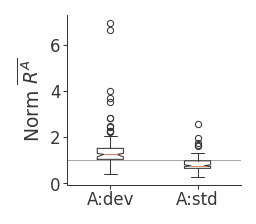

In [20]:
def panel_response_stats_2(ax, widths=.3):
    n = nspikes[cfg.ISIs[0]][1][1]
    ax.axhline(1, **styling.axline_kwargs)
    ax.boxplot((n['dev']/n['msc'], n['std']/n['msc']), notch=True, bootstrap=10000, labels=(pu.sseq['dev'], pu.sseq['std']), widths=widths)
    ax.set_ylabel(f'Norm ${pu.R(stim="A", mean=True, index=" ")}$')
    sns.despine(ax=ax)

    test = stats.wilcoxon(n['dev'], n['msc'], alternative='greater', method='approx')
    print(f'dev > msc : Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')
    test = stats.wilcoxon(n['std'], n['msc'], alternative='less', method='approx')
    print(f'std < msc : Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}')

fig, ax = plt.subplots(figsize=(1.5,1.5), dpi=150)
panel_response_stats_2(ax)

DDI > 0 : Z = 6.12, p = 4.75e-10, median 0.114


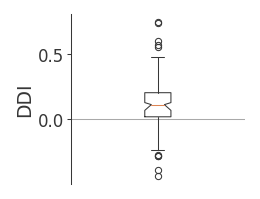

In [21]:
def panel_ddi_stats_2(ax):
    n = nspikes[cfg.ISIs[0]][1][1]
    ax.axhline(0, **styling.axline_kwargs)
    ddi = index(n['dev'], n['msc'])
    ax.boxplot((ddi,), notch=True, bootstrap=10000)
    ax.set_xticks([])
    ax.set_ylabel('DDI')
    sns.despine(ax=ax, bottom=True)

    test = stats.wilcoxon(ddi, alternative='greater', method='approx')
    print(f'DDI > 0 : Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median {np.median(ddi):.3g}')

fig, ax = plt.subplots(figsize=(1.5,1.5), dpi=150)
panel_ddi_stats_2(ax)

<dev-std> > 0 : Z = 7.95, p = 9.26e-16, median 0.253
<msc-std> > 0 : Z = 6.71, p = 9.76e-12, median 0.135
<dev-msc> > 0 : Z = 6.12, p = 4.75e-10, median 0.114


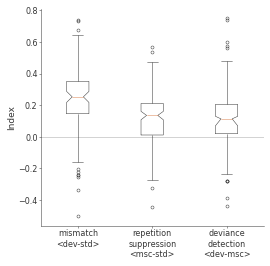

In [22]:
def panel_stats_2(ax):
    n = nspikes[cfg.ISIs[0]][1][1]
    ax.axhline(0, **styling.axline_kwargs)
    ax.boxplot((
        index(n['dev'], n['std']),
        index(n['msc'], n['std']),
        index(n['dev'], n['msc']),
    ), notch=True, bootstrap=10000)
    ax.set_xticks(range(1,4), ('mismatch\n<dev-std>', 'repetition\nsuppression\n<msc-std>', 'deviance\ndetection\n<dev-msc>'))
    ax.set_ylabel('Index')
    sns.despine(ax=ax)

    for n0,n1 in (('dev', 'std'), ('msc','std'), ('dev','msc')):
        ix = index(n[n0], n[n1])
        test = stats.wilcoxon(ix, alternative='greater', method='approx')
        print(f'<{n0}-{n1}> > 0 : Z = {test.zstatistic:.3g}, p = {test.pvalue:.3g}, median {np.median(ix):.3g}')

fig, ax = plt.subplots(figsize=(4,4))
panel_stats_2(ax)

Grey distribution ignores 204 neurons.
dev > msc : Z = 7.21, p = 2.75e-13
std < msc : Z = -7.71, p = 6.42e-15
DDI > 0 : Z = 6.12, p = 4.75e-10, median 0.114


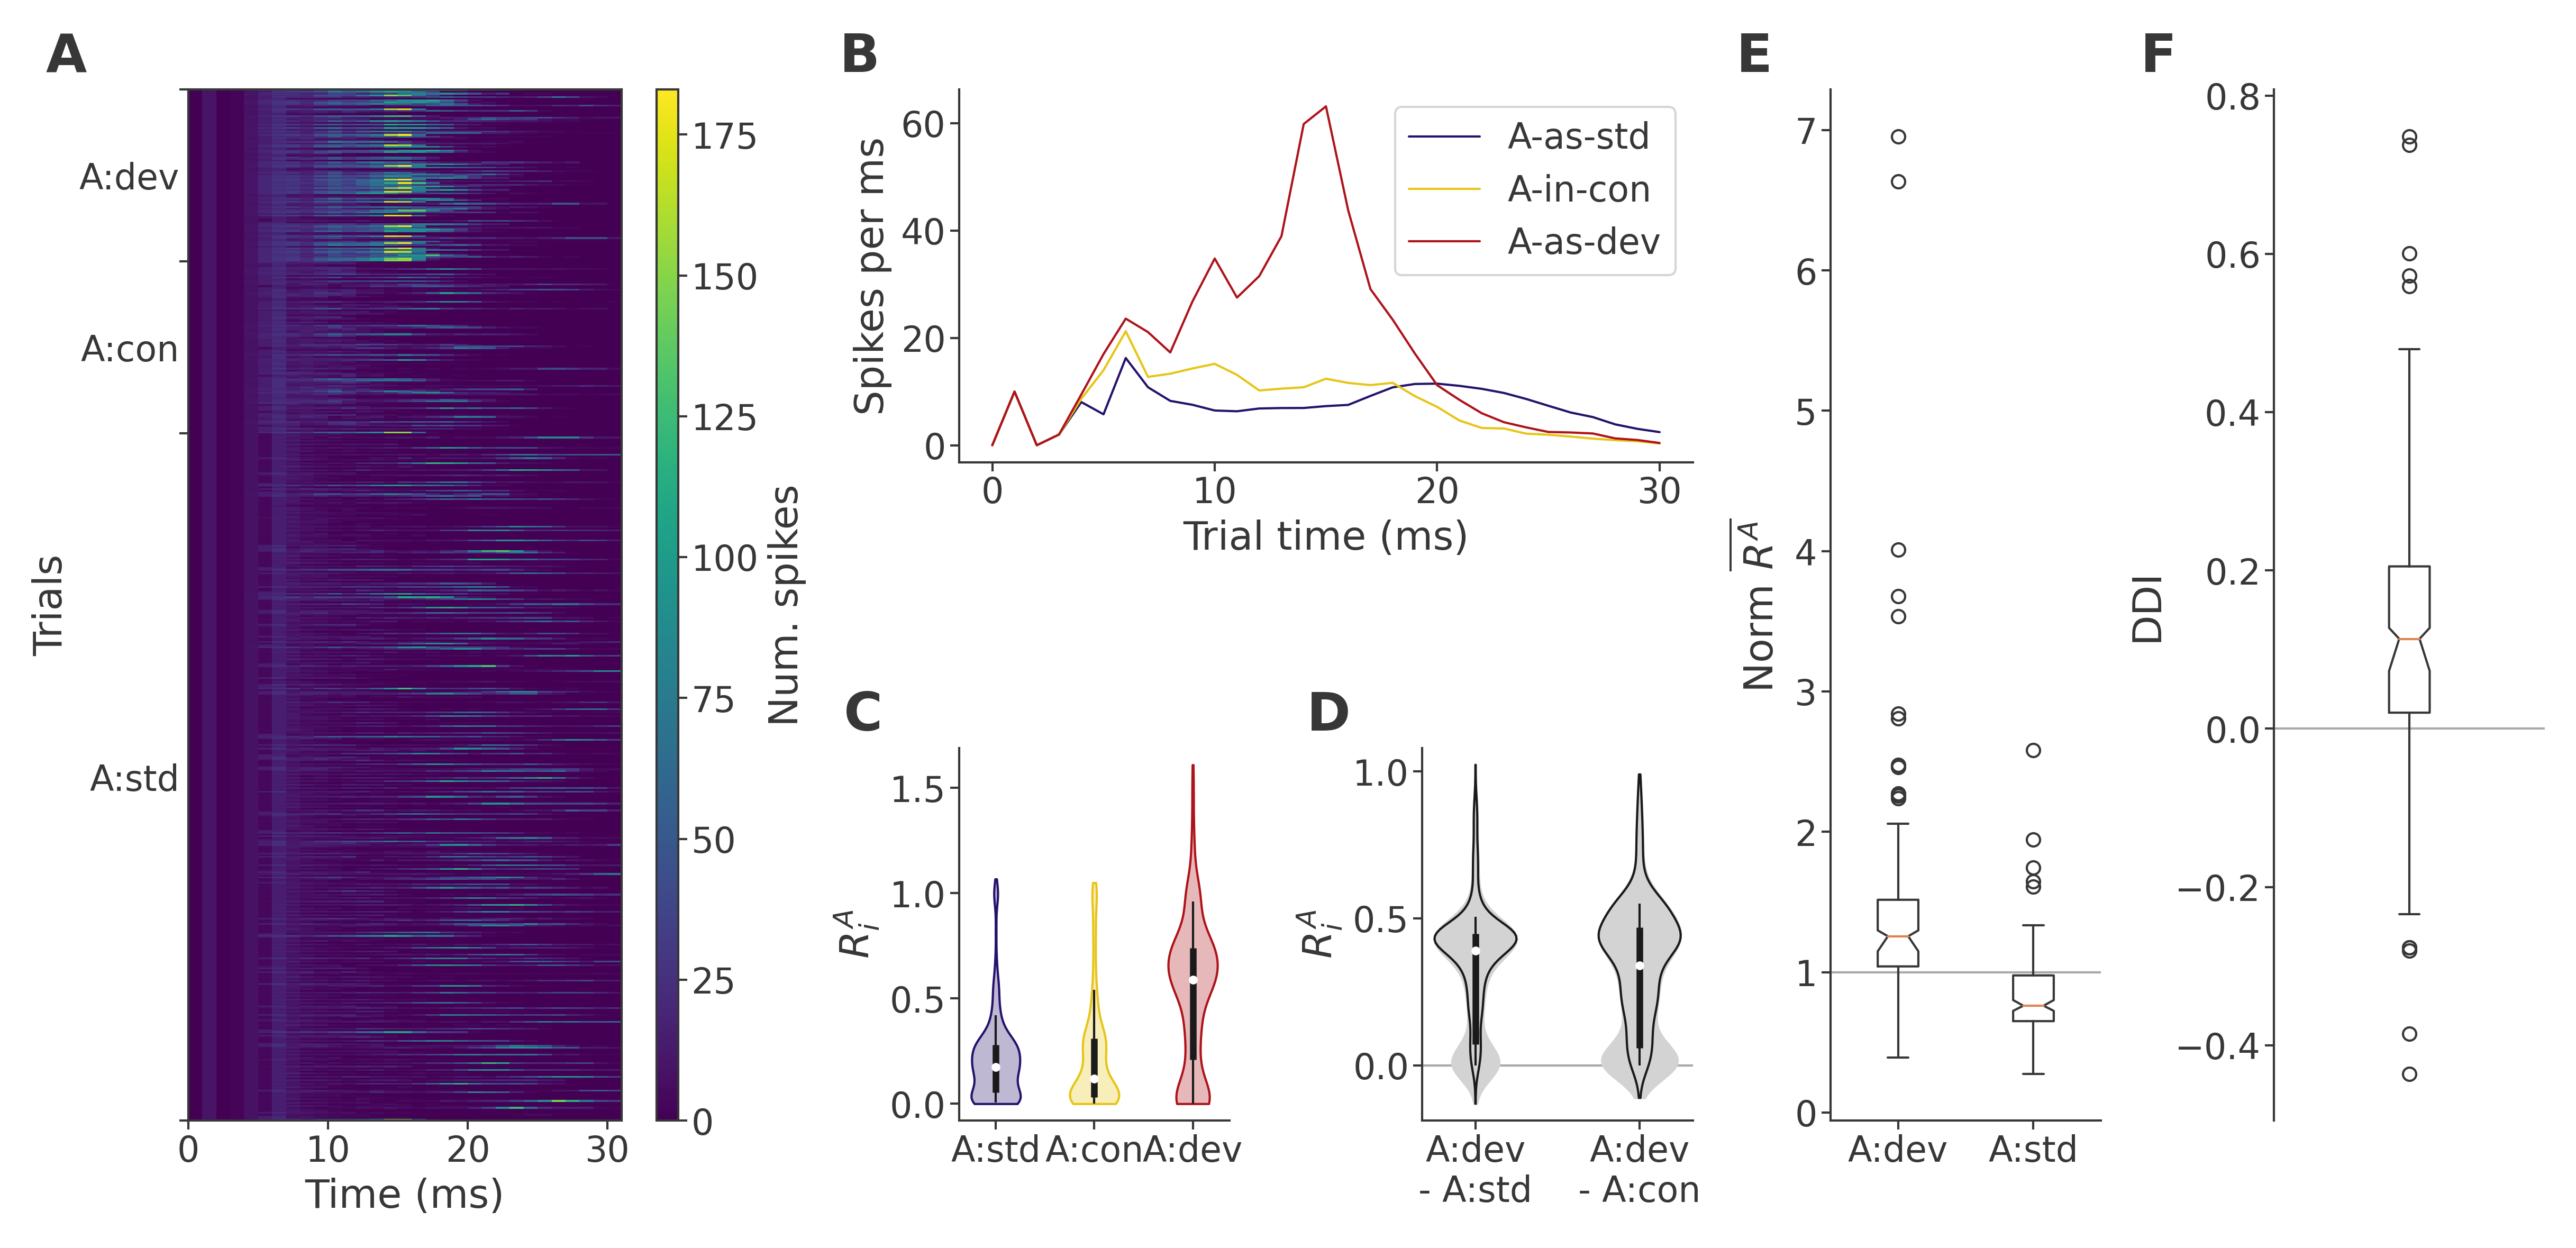

In [23]:
fig = plt.figure(figsize=pu.fullwidth(3), dpi=600, layout='compressed')
gs = fig.add_gridspec(2, 6, width_ratios=(8, .4, 5, 5, 5, 5))

axs = fig.add_subplot(gs[:, 0]), fig.add_subplot(gs[:, 1])
panel_raster(*axs, bspikes[1][1])
pu.label_panel(axs[0], 0)

ax = fig.add_subplot(gs[0, 2:4])
panel_response(ax, bspikes[1][1], cfg.params['dt'])
pu.label_panel(ax, 1)

ax = fig.add_subplot(gs[1, 2])
panel_neuron_responses(ax)
pu.label_panel(ax, 2)

ax = fig.add_subplot(gs[1, 3])
panel_neuron_contrast(ax)
pu.label_panel(ax, 3)

ax = fig.add_subplot(gs[:, 4])
panel_response_stats_2(ax)
pu.label_panel(ax, 4)

ax = fig.add_subplot(gs[:, 5])
panel_ddi_stats_2(ax)
pu.label_panel(ax, 5)

plt.savefig('paper-1/Fig2.tif', pil_kwargs={"compression": "tiff_lzw"}, dpi=600)
plt.savefig('paper-1/fig-dd.pdf')